# Invisible Robust Watermarking

In [2]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

# --- Helper functions for evaluation ---

def calculate_psnr(original, watermarked):
    """Calculates the Peak Signal-to-Noise Ratio between two images."""
    mse = np.mean((original - watermarked) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_ber(original_watermark, extracted_watermark):
    """Calculates the Bit Error Rate between two watermarks."""
    original_flat = original_watermark.flatten().astype(int)
    extracted_flat = extracted_watermark.flatten().astype(int)
    
    # Ensure they are binary
    original_flat[original_flat > 0] = 1
    extracted_flat[extracted_flat > 0] = 1
    
    errors = np.sum(original_flat != extracted_flat)
    total_bits = len(original_flat)
    
    return errors / total_bits

In [6]:
def embed_watermark(host_image_path, watermark_image_path, alpha=0.1):
    """
    Embeds a watermark into a host image using DWT and SVD.
    
    Args:
        host_image_path (str): Path to the color host image.
        watermark_image_path (str): Path to the 64x64 monochrome watermark.
        alpha (float): Embedding strength factor (quantization step).

    Returns:
        numpy.ndarray: The watermarked image in BGR format.
    """
    # 1. --- Preprocessing ---
    # Read images
    host_img = cv2.imread(host_image_path)
    watermark_img = cv2.imread(watermark_image_path, cv2.IMREAD_GRAYSCALE)
    
    if host_img is None or watermark_img is None:
        raise FileNotFoundError("Could not read one of the images. Check paths.")
        
    # Convert watermark to a 1D binary array
    watermark_flat = watermark_img.flatten()
    watermark_flat[watermark_flat > 0] = 1 # Ensure binary
    
    # Convert host image to YCbCr and get the Y channel
    ycbcr_host = cv2.cvtColor(host_img, cv2.COLOR_BGR2YCrCb)
    y_host, cr_host, cb_host = cv2.split(ycbcr_host)

    # 2. --- Decomposition (DWT) ---
    # Apply 2-level DWT on the Y channel
    coeffs_y = pywt.dwt2(y_host, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs_y
    coeffs_LL1 = pywt.dwt2(LL1, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs_LL1

    # 3. --- Embedding (SVD) ---
    # We will embed in the LH2 and HL2 sub-bands
    sub_bands_to_embed = [LH2, HL2]
    watermark_idx = 0
    
    for sub_band in sub_bands_to_embed:
        if watermark_idx >= len(watermark_flat):
            break
        
        # Divide the sub-band into 4x4 blocks
        for i in range(0, sub_band.shape[0], 4):
            for j in range(0, sub_band.shape[1], 4):
                if watermark_idx >= len(watermark_flat):
                    break
                
                block = sub_band[i:i+4, j:j+4]
                
                # Apply SVD
                U, S, Vt = np.linalg.svd(block)
                
                # Modify the largest singular value based on watermark bit
                # This is a form of Quantization Index Modulation (QIM)
                w_bit = watermark_flat[watermark_idx]
                S[0] = S[0] + alpha * S[0] * w_bit
                
                # Reconstruct the block
                modified_block = U @ np.diag(S) @ Vt
                sub_band[i:i+4, j:j+4] = modified_block
                
                watermark_idx += 1
    
    # 4. --- Reconstruction ---
    # Reconstruct the DWT levels
    coeffs_LL1_modified = (LL2, (LH2, HL2, HH2))
    LL1_modified = pywt.idwt2(coeffs_LL1_modified, 'haar')

    LL1_modified = LL1_modified[:LH1.shape[0], :LH1.shape[1]]
    
    coeffs_y_modified = (LL1_modified, (LH1, HL1, HH1))
    y_host_modified = pywt.idwt2(coeffs_y_modified, 'haar')

    y_host_modified = y_host_modified[:y_host.shape[0], :y_host.shape[1]]

    # Clip values to be in the valid [0, 255] range
    y_host_modified = np.clip(y_host_modified, 0, 255)

    # Combine modified Y channel with original Cb and Cr
    watermarked_ycbcr = cv2.merge([y_host_modified.astype('uint8'), cr_host, cb_host])
    
    # Convert back to BGR
    watermarked_img = cv2.cvtColor(watermarked_ycbcr, cv2.COLOR_YCrCb2BGR)

    return watermarked_img

In [7]:
def extract_watermark(watermarked_img, original_host_path, watermark_shape, alpha=0.1):
    """
    Extracts the watermark from a watermarked image. This is a blind extraction.

    Args:
        watermarked_img (numpy.ndarray): The watermarked image (potentially attacked).
        original_host_path (str): Path to the original host image to get original singular values.
        watermark_shape (tuple): The shape of the original watermark (e.g., (64, 64)).
        alpha (float): The same embedding strength factor.

    Returns:
        numpy.ndarray: The extracted monochrome watermark.
    """
    # --- Get original singular values (part of the 'key') ---
    original_host = cv2.imread(original_host_path)
    ycbcr_orig = cv2.cvtColor(original_host, cv2.COLOR_BGR2YCrCb)
    y_orig, _, _ = cv2.split(ycbcr_orig)
    coeffs_orig = pywt.dwt2(y_orig, 'haar')
    LL1_orig, _ = coeffs_orig
    coeffs_LL1_orig = pywt.dwt2(LL1_orig, 'haar')
    _, (LH2_orig, HL2_orig, _) = coeffs_LL1_orig
    
    original_S_values = []
    for sub_band in [LH2_orig, HL2_orig]:
        for i in range(0, sub_band.shape[0], 4):
            for j in range(0, sub_band.shape[1], 4):
                block = sub_band[i:i+4, j:j+4]
                _, S, _ = np.linalg.svd(block)
                original_S_values.append(S[0])
                
    # 1. --- Decomposition ---
    ycbcr_wm = cv2.cvtColor(watermarked_img, cv2.COLOR_BGR2YCrCb)
    y_wm, _, _ = cv2.split(ycbcr_wm)
    
    coeffs_wm = pywt.dwt2(y_wm, 'haar')
    LL1_wm, _ = coeffs_wm
    coeffs_LL1_wm = pywt.dwt2(LL1_wm, 'haar')
    _, (LH2_wm, HL2_wm, _) = coeffs_LL1_wm

    # 2. --- Extraction ---
    extracted_bits = []
    s_idx = 0
    sub_bands_to_extract = [LH2_wm, HL2_wm]

    for sub_band in sub_bands_to_extract:
        if s_idx >= len(original_S_values):
            break
        for i in range(0, sub_band.shape[0], 4):
            for j in range(0, sub_band.shape[1], 4):
                if s_idx >= len(original_S_values):
                    break
                
                block = sub_band[i:i+4, j:j+4]
                _, S_wm, _ = np.linalg.svd(block)
                
                # Retrieve original singular value
                S_orig = original_S_values[s_idx]
                
                # Compare and decide the bit
                diff = S_wm[0] - S_orig
                if diff > (alpha * S_orig * 0.5):
                    extracted_bits.append(1)
                else:
                    extracted_bits.append(0)
                
                s_idx += 1
                
    # 3. --- Reconstruction ---
    extracted_watermark_flat = np.array(extracted_bits[:watermark_shape[0] * watermark_shape[1]])
    extracted_watermark = extracted_watermark_flat.reshape(watermark_shape) * 255
    
    return extracted_watermark.astype('uint8')

Embedding watermark...
Embedding complete.
PSNR of watermarked image: 39.16 dB (Higher is better)

Simulating JPEG compression attack...
Attack complete.

Extracting watermark from attacked image...
Extraction complete.
Bit Error Rate (BER) after attack: 0.3943 (Lower is better, 0 is perfect)


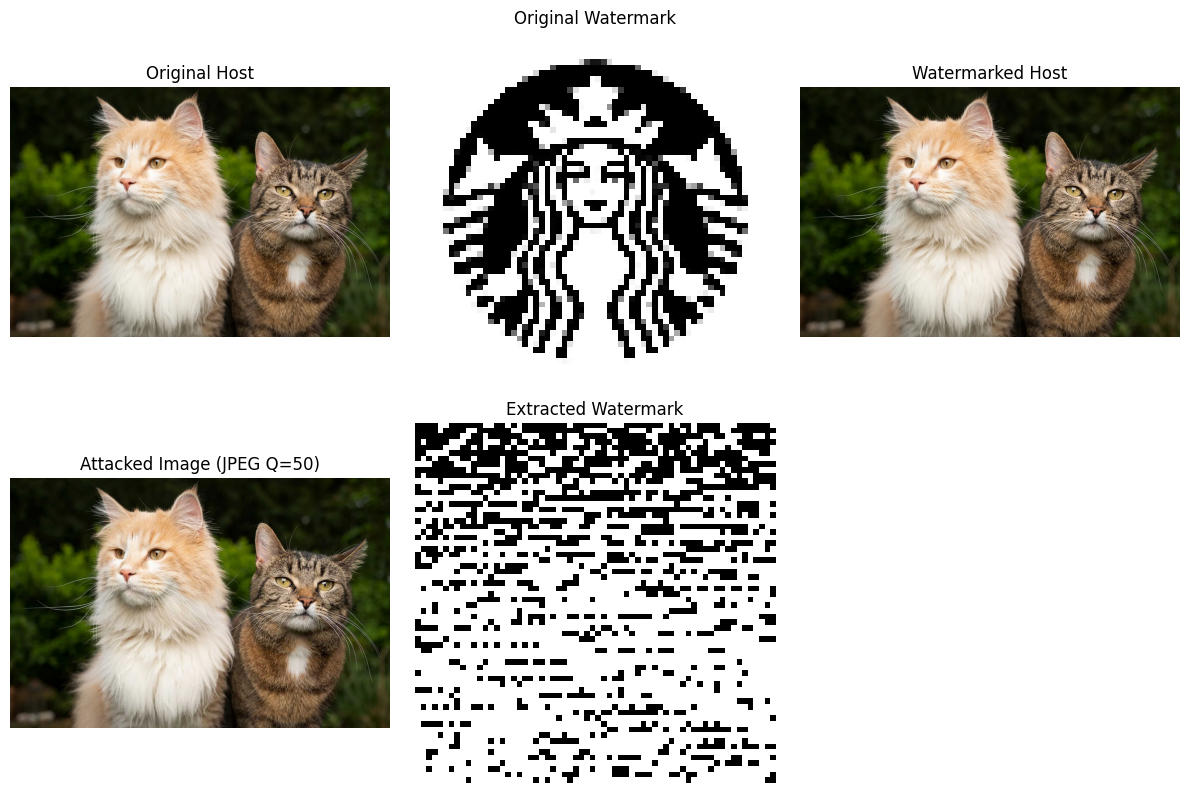

In [13]:
if __name__ == '__main__':
    # --- Configuration ---
    HOST_IMG_PATH = 'images/cat.webp'
    WATERMARK_IMG_PATH = 'images/s.jpg'
    WATERMARKED_IMG_PATH = 'watermarked_image.png'
    ATTACKED_IMG_PATH = 'attacked_image.jpg' # Save as JPG for compression attack
    
    # # Create a dummy 64x64 watermark image
    # dummy_watermark = np.zeros((64, 64), dtype='uint8')
    # dummy_watermark[10:54, 10:20] = 255 # A simple bar pattern
    # dummy_watermark[10:54, 30:40] = 255
    # cv2.imwrite(WATERMARK_IMG_PATH, dummy_watermark)

    dummy_watermark = cv2.imread(WATERMARK_IMG_PATH, cv2.IMREAD_GRAYSCALE)
    dummy_watermark = cv2.resize(dummy_watermark, (64, 64))  # Ensure it's 64x64

    # --- 1. Embedding ---
    print("Embedding watermark...")
    watermarked_image = embed_watermark(HOST_IMG_PATH, WATERMARK_IMG_PATH, alpha=0.5)
    cv2.imwrite(WATERMARKED_IMG_PATH, watermarked_image)
    print("Embedding complete.")
    
    # --- 2. Evaluation (before attack) ---
    original_host = cv2.imread(HOST_IMG_PATH)
    psnr_val = calculate_psnr(original_host, watermarked_image)
    print(f"PSNR of watermarked image: {psnr_val:.2f} dB (Higher is better)")
    
    # --- 3. Simulate JPEG Attack ---
    print("\nSimulating JPEG compression attack...")
    # Save with low quality (high compression)
    cv2.imwrite(ATTACKED_IMG_PATH, watermarked_image, [cv2.IMWRITE_JPEG_QUALITY, 50])
    attacked_image = cv2.imread(ATTACKED_IMG_PATH)
    print("Attack complete.")

    # --- 4. Extraction ---
    print("\nExtracting watermark from attacked image...")
    extracted_wm = extract_watermark(attacked_image, HOST_IMG_PATH, (64, 64), alpha=0.5)
    print("Extraction complete.")
    
    # --- 5. Final Evaluation ---
    ber_val = calculate_ber(dummy_watermark, extracted_wm)
    print(f"Bit Error Rate (BER) after attack: {ber_val:.4f} (Lower is better, 0 is perfect)")
    
    # --- 6. Display Results ---
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(original_host, cv2.COLOR_BGR2RGB))
    plt.title('Original Host')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(dummy_watermark, cmap='gray')
    plt.title('Original Watermark')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(watermarked_image, cv2.COLOR_BGR2RGB))
    plt.title('Watermarked Host')
    plt.axis('off')
    
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(attacked_image, cv2.COLOR_BGR2RGB))
    plt.title('Attacked Image (JPEG Q=50)')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(extracted_wm, cmap='gray')
    plt.title('Extracted Watermark')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

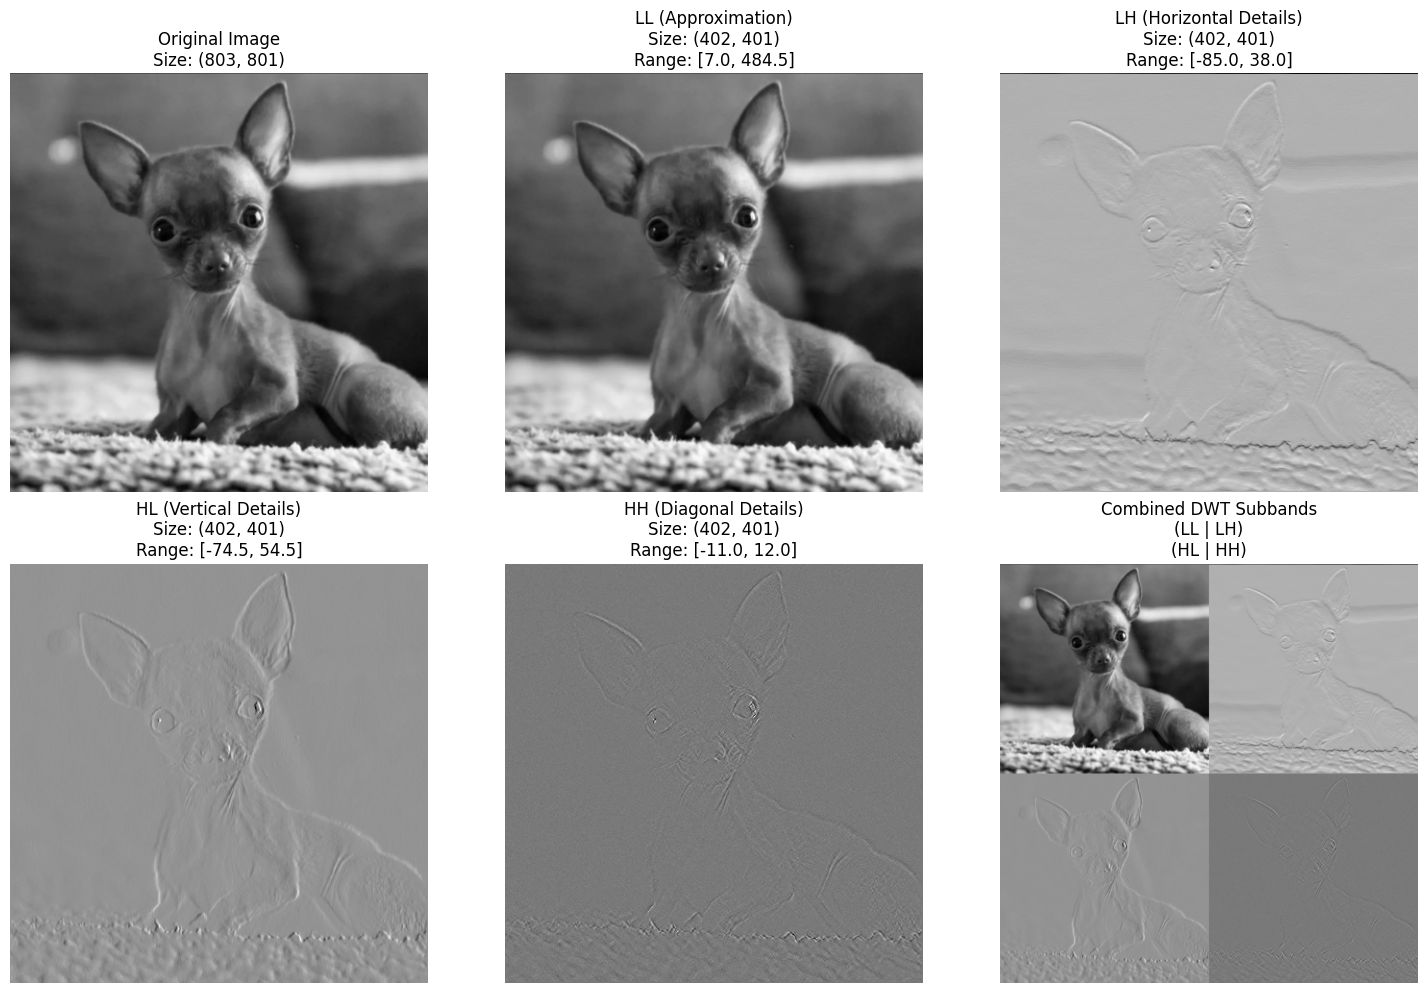

=== DWT Coefficient Statistics ===
Original image shape: (803, 801)
LL (Approximation) - Shape: (402, 401), Mean: 208.09, Std: 101.59
LH (Horizontal) - Shape: (402, 401), Mean: -0.15, Std: 5.11
HL (Vertical) - Shape: (402, 401), Mean: -0.01, Std: 3.18
HH (Diagonal) - Shape: (402, 401), Mean: 0.00, Std: 0.50

=== Sample Coefficient Values (Top-left 5x5) ===
LL coefficients:
[[156.5 159.  157.5 155.5 156. ]
 [211.  215.5 213.  210.  210.5]
 [211.5 214.5 213.  210.  210.5]
 [215.  214.5 213.5 210.5 209. ]
 [216.5 215.  214.  211.  207.5]]

LH coefficients:
[[-54.5 -57.  -55.5 -53.5 -54. ]
 [  0.    0.5   0.    0.   -0.5]
 [ -0.5   0.5   0.    0.    0.5]
 [ -1.   -0.5  -0.5  -0.5   1. ]
 [ -0.5   0.    0.    0.    0.5]]

HL coefficients:
[[-0.5  0.   0.5  0.5  0. ]
 [-1.  -0.5  1.   0.  -0.5]
 [-0.5 -0.5  1.   0.  -0.5]
 [ 0.   0.5  0.5  0.5  0. ]
 [ 0.5  1.   0.   1.   0.5]]

HH coefficients:
[[ 0.5  0.  -0.5 -0.5  0. ]
 [ 0.   0.5  0.   0.   0.5]
 [-0.5 -0.5  0.   0.  -0.5]
 [ 0.  -0.5  

In [16]:
import pywt
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and process the image
image = cv2.imread(r"ss_watermarked.png")
# Convert to grayscale for cleaner DWT visualization
ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

feature_image, _, _ = cv2.split(ycbcr)

# Apply DWT
coeffs = pywt.dwt2(feature_image, 'haar')
LL, (LH, HL, HH) = coeffs

# Function to normalize coefficients for display
def normalize_for_display(coeff):
    """Normalize coefficients to 0-255 range for visualization"""
    coeff_norm = coeff.copy()
    coeff_norm = (coeff_norm - np.min(coeff_norm)) / (np.max(coeff_norm) - np.min(coeff_norm))
    return (coeff_norm * 255).astype(np.uint8)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image
axes[0, 0].imshow(feature_image, cmap='gray')
axes[0, 0].set_title(f'Original Image\nSize: {feature_image.shape}')
axes[0, 0].axis('off')

# LL subband (approximation - low frequencies)
axes[0, 1].imshow(normalize_for_display(LL), cmap='gray')
axes[0, 1].set_title(f'LL (Approximation)\nSize: {LL.shape}\nRange: [{LL.min():.1f}, {LL.max():.1f}]')
axes[0, 1].axis('off')

# LH subband (horizontal details)
axes[0, 2].imshow(normalize_for_display(LH), cmap='gray')
axes[0, 2].set_title(f'LH (Horizontal Details)\nSize: {LH.shape}\nRange: [{LH.min():.1f}, {LH.max():.1f}]')
axes[0, 2].axis('off')

# HL subband (vertical details)
axes[1, 0].imshow(normalize_for_display(HL), cmap='gray')
axes[1, 0].set_title(f'HL (Vertical Details)\nSize: {HL.shape}\nRange: [{HL.min():.1f}, {HL.max():.1f}]')
axes[1, 0].axis('off')

# HH subband (diagonal details)
axes[1, 1].imshow(normalize_for_display(HH), cmap='gray')
axes[1, 1].set_title(f'HH (Diagonal Details)\nSize: {HH.shape}\nRange: [{HH.min():.1f}, {HH.max():.1f}]')
axes[1, 1].axis('off')

# Reconstructed DWT visualization (all subbands combined)
# Create a combined visualization of all subbands
h, w = LL.shape
combined = np.zeros((2*h, 2*w))
combined[0:h, 0:w] = normalize_for_display(LL)
combined[0:h, w:2*w] = normalize_for_display(LH)
combined[h:2*h, 0:w] = normalize_for_display(HL)
combined[h:2*h, w:2*w] = normalize_for_display(HH)

axes[1, 2].imshow(combined, cmap='gray')
axes[1, 2].set_title('Combined DWT Subbands\n(LL | LH)\n(HL | HH)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("=== DWT Coefficient Statistics ===")
print(f"Original image shape: {feature_image.shape}")
print(f"LL (Approximation) - Shape: {LL.shape}, Mean: {LL.mean():.2f}, Std: {LL.std():.2f}")
print(f"LH (Horizontal) - Shape: {LH.shape}, Mean: {LH.mean():.2f}, Std: {LH.std():.2f}")
print(f"HL (Vertical) - Shape: {HL.shape}, Mean: {HL.mean():.2f}, Std: {HL.std():.2f}")
print(f"HH (Diagonal) - Shape: {HH.shape}, Mean: {HH.mean():.2f}, Std: {HH.std():.2f}")

# Display a small sample of actual coefficient values
print("\n=== Sample Coefficient Values (Top-left 5x5) ===")
print("LL coefficients:")
print(LL[:5, :5])
print("\nLH coefficients:")
print(LH[:5, :5])
print("\nHL coefficients:")
print(HL[:5, :5])
print("\nHH coefficients:")
print(HH[:5, :5])

=== EMBEDDING ===
Watermark bits: 4096
LH2 shape: (264, 400)
LH shape: (264, 400), Tiles: 4x6 = 24
Using tiled embedding with 24 tiles
PSNR: 44.21 dB

=== EXTRACTION (No Attack) ===
Majority voting from 24 tiles
BER (no attack): 0.6187

=== EXTRACTION (After JPEG Attack) ===
Majority voting from 24 tiles
BER (after attack): 0.6580


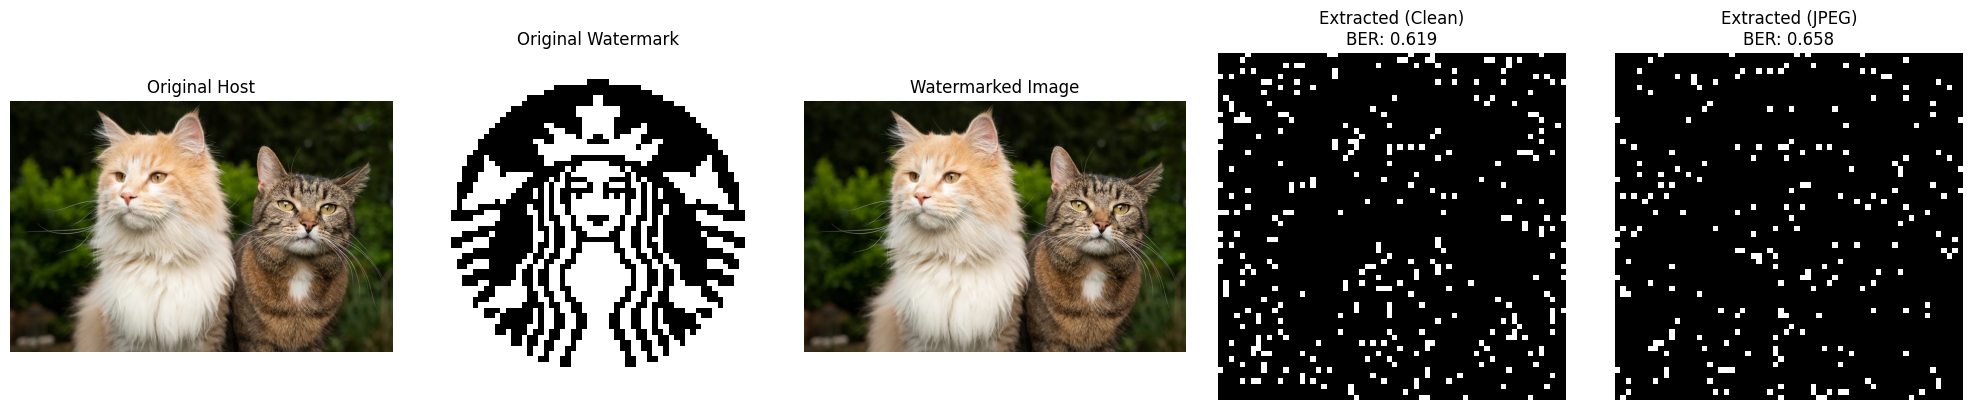

In [20]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

def create_seeded_positions(lh_shape, watermark_bits, seed=12345, min_magnitude=0.1):
    """
    Create seeded, permuted positions in LH subband for embedding.
    
    Args:
        lh_shape: Shape of LH subband (H, W)
        watermark_bits: Number of bits to embed
        seed: Secret seed for reproducible positioning
        min_magnitude: Minimum coefficient magnitude threshold
    
    Returns:
        List of (row, col) positions for embedding
    """
    np.random.seed(seed)
    H, W = lh_shape
    
    # Create all possible positions
    all_positions = [(i, j) for i in range(H) for j in range(W)]
    
    # Shuffle with seeded PRNG
    np.random.shuffle(all_positions)
    
    # Take first watermark_bits positions
    selected_positions = all_positions[:watermark_bits]
    
    return selected_positions

def create_tiled_positions(lh_shape, tile_size, watermark_bits, seed=12345):
    """
    Create tiled embedding positions with redundant copies.
    
    Args:
        lh_shape: Shape of LH subband (H, W)
        tile_size: Size of each tile (e.g., 64)
        watermark_bits: Number of bits in watermark
        seed: Secret seed
    
    Returns:
        Dictionary mapping tile_id to list of positions within that tile
    """
    np.random.seed(seed)
    H, W = lh_shape
    
    # Calculate number of tiles
    tiles_h = H // tile_size
    tiles_w = W // tile_size
    total_tiles = tiles_h * tiles_w
    
    print(f"LH shape: {lh_shape}, Tiles: {tiles_h}x{tiles_w} = {total_tiles}")
    
    if total_tiles == 0:
        raise ValueError("LH subband too small for tiling")
    
    # For each tile, create positions within the tile
    tiled_positions = {}
    
    for tile_h in range(tiles_h):
        for tile_w in range(tiles_w):
            tile_id = tile_h * tiles_w + tile_w
            
            # Create positions within this tile
            tile_positions = []
            tile_start_h = tile_h * tile_size
            tile_start_w = tile_w * tile_size
            
            # Generate positions within tile
            local_positions = [(i, j) for i in range(tile_size) 
                             for j in range(tile_size)]
            np.random.shuffle(local_positions)
            
            # Convert to global coordinates and take first watermark_bits
            for i, (local_h, local_w) in enumerate(local_positions[:watermark_bits]):
                global_h = tile_start_h + local_h
                global_w = tile_start_w + local_w
                tile_positions.append((global_h, global_w))
            
            tiled_positions[tile_id] = tile_positions
    
    return tiled_positions, total_tiles

def embed_with_seeded_tiling(host_image_path, watermark_image_path, seed=12345, 
                           alpha=0.1, tile_size=64, use_tiling=True):
    """
    Embed watermark with seeded positioning and optional tiling.
    """
    # Load and preprocess
    host_img = cv2.imread(host_image_path)
    watermark_img = cv2.imread(watermark_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize watermark to 64x64 and convert to bits
    watermark_64 = cv2.resize(watermark_img, (64, 64))
    _, watermark_binary = cv2.threshold(watermark_64, 128, 1, cv2.THRESH_BINARY)
    watermark_bits = watermark_binary.flatten()
    
    print(f"Watermark bits: {len(watermark_bits)}")
    
    # Convert to YCbCr and apply DWT
    ycbcr_host = cv2.cvtColor(host_img, cv2.COLOR_BGR2YCrCb)
    y_host, cr_host, cb_host = cv2.split(ycbcr_host)
    
    # 2-level DWT
    coeffs_y = pywt.dwt2(y_host, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs_y
    coeffs_LL1 = pywt.dwt2(LL1, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs_LL1
    
    print(f"LH2 shape: {LH2.shape}")
    
    # Choose embedding strategy
    if use_tiling and LH2.shape[0] >= tile_size and LH2.shape[1] >= tile_size:
        # Tiled embedding
        tiled_positions, total_tiles = create_tiled_positions(
            LH2.shape, tile_size, len(watermark_bits), seed
        )
        
        print(f"Using tiled embedding with {total_tiles} tiles")
        
        # Embed in each tile
        for tile_id, positions in tiled_positions.items():
            for bit_idx, (h, w) in enumerate(positions):
                if bit_idx < len(watermark_bits):
                    # QIM embedding
                    original_coeff = LH2[h, w]
                    watermark_bit = watermark_bits[bit_idx]
                    
                    # Simple additive embedding
                    LH2[h, w] = original_coeff + alpha * original_coeff * watermark_bit
        
        embedding_info = {
            'method': 'tiled',
            'tile_size': tile_size,
            'total_tiles': total_tiles,
            'positions': tiled_positions
        }
        
    else:
        # Simple seeded positioning
        positions = create_seeded_positions(LH2.shape, len(watermark_bits), seed)
        
        print(f"Using simple seeded embedding with {len(positions)} positions")
        
        # Embed bits
        for bit_idx, (h, w) in enumerate(positions):
            original_coeff = LH2[h, w]
            watermark_bit = watermark_bits[bit_idx]
            LH2[h, w] = original_coeff + alpha * original_coeff * watermark_bit
        
        embedding_info = {
            'method': 'simple',
            'positions': positions
        }
    
    # Reconstruct image
    coeffs_LL1_modified = (LL2, (LH2, HL2, HH2))
    LL1_modified = pywt.idwt2(coeffs_LL1_modified, 'haar')
    LL1_modified = LL1_modified[:LH1.shape[0], :LH1.shape[1]]
    
    coeffs_y_modified = (LL1_modified, (LH1, HL1, HH1))
    y_host_modified = pywt.idwt2(coeffs_y_modified, 'haar')
    y_host_modified = y_host_modified[:y_host.shape[0], :y_host.shape[1]]
    y_host_modified = np.clip(y_host_modified, 0, 255)
    
    watermarked_ycbcr = cv2.merge([y_host_modified.astype('uint8'), cr_host, cb_host])
    watermarked_img = cv2.cvtColor(watermarked_ycbcr, cv2.COLOR_YCrCb2BGR)
    
    return watermarked_img, embedding_info, watermark_bits

def extract_with_seeded_tiling(watermarked_img, original_host_path, embedding_info, 
                             original_watermark_bits, seed=12345, alpha=0.1):
    """
    Extract watermark using the same seeded positions.
    """
    # Get original coefficients for comparison
    original_host = cv2.imread(original_host_path)
    ycbcr_orig = cv2.cvtColor(original_host, cv2.COLOR_BGR2YCrCb)
    y_orig, _, _ = cv2.split(ycbcr_orig)
    
    coeffs_orig = pywt.dwt2(y_orig, 'haar')
    LL1_orig, _ = coeffs_orig
    coeffs_LL1_orig = pywt.dwt2(LL1_orig, 'haar')
    _, (LH2_orig, _, _) = coeffs_LL1_orig
    
    # Process watermarked image
    ycbcr_wm = cv2.cvtColor(watermarked_img, cv2.COLOR_BGR2YCrCb)
    y_wm, _, _ = cv2.split(ycbcr_wm)
    
    coeffs_wm = pywt.dwt2(y_wm, 'haar')
    LL1_wm, _ = coeffs_wm
    coeffs_LL1_wm = pywt.dwt2(LL1_wm, 'haar')
    _, (LH2_wm, _, _) = coeffs_LL1_wm
    
    if embedding_info['method'] == 'tiled':
        # Extract from all tiles and majority vote
        tile_results = []
        
        for tile_id, positions in embedding_info['positions'].items():
            tile_bits = []
            
            for bit_idx, (h, w) in enumerate(positions):
                if bit_idx < len(original_watermark_bits):
                    original_coeff = LH2_orig[h, w]
                    watermarked_coeff = LH2_wm[h, w]
                    
                    # Simple threshold-based extraction
                    diff = watermarked_coeff - original_coeff
                    threshold = alpha * abs(original_coeff) * 0.5
                    extracted_bit = 1 if diff > threshold else 0
                    tile_bits.append(extracted_bit)
            
            tile_results.append(tile_bits)
        
        # Majority voting across tiles
        extracted_bits = []
        for bit_idx in range(len(original_watermark_bits)):
            votes = [tile_result[bit_idx] for tile_result in tile_results 
                    if bit_idx < len(tile_result)]
            
            if votes:
                extracted_bit = 1 if sum(votes) > len(votes) // 2 else 0
                extracted_bits.append(extracted_bit)
        
        print(f"Majority voting from {len(tile_results)} tiles")
        
    else:
        # Simple extraction from seeded positions
        positions = create_seeded_positions(LH2_wm.shape, len(original_watermark_bits), seed)
        extracted_bits = []
        
        for bit_idx, (h, w) in enumerate(positions):
            original_coeff = LH2_orig[h, w]
            watermarked_coeff = LH2_wm[h, w]
            
            # FIXED: Better threshold
            diff = watermarked_coeff - original_coeff
            threshold = alpha * abs(original_coeff) * 0.5
            extracted_bit = 1 if diff > threshold else 0
            extracted_bits.append(extracted_bit)
    
    # FIXED: Return bits directly, not scaled image
    return np.array(extracted_bits)

# Example usage
if __name__ == '__main__':
    HOST_IMG_PATH = 'images/cat.webp'
    WATERMARK_IMG_PATH = 'images/s.jpg'
    SEED = 12345
    ALPHA = 0.3
    
    # Embedding
    print("=== EMBEDDING ===")
    watermarked_img, embedding_info, original_bits = embed_with_seeded_tiling(
        HOST_IMG_PATH, WATERMARK_IMG_PATH, seed=SEED, alpha=ALPHA, 
        tile_size=64, use_tiling=True
    )
    
    cv2.imwrite('watermarked_seeded.png', watermarked_img)
    
    # Calculate PSNR
    original_host = cv2.imread(HOST_IMG_PATH)
    mse = np.mean((original_host - watermarked_img) ** 2)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse)) if mse > 0 else float('inf')
    print(f"PSNR: {psnr:.2f} dB")
    
    # Test extraction on original watermarked image (no attack)
    print("\n=== EXTRACTION (No Attack) ===")
    extracted_bits_clean = extract_with_seeded_tiling(
        watermarked_img, HOST_IMG_PATH, embedding_info, original_bits, 
        seed=SEED, alpha=ALPHA
    )
    
    # FIXED: Proper BER calculation with consistent bit format
    ber_clean = np.mean(original_bits != extracted_bits_clean)
    print(f"BER (no attack): {ber_clean:.4f}")
    
    # Simulate attack (JPEG compression)
    cv2.imwrite('attacked_seeded.jpg', watermarked_img, [cv2.IMWRITE_JPEG_QUALITY, 50])
    attacked_img = cv2.imread('attacked_seeded.jpg')

    # Extraction after attack
    print("\n=== EXTRACTION (After JPEG Attack) ===")
    extracted_bits_attacked = extract_with_seeded_tiling(
        attacked_img, HOST_IMG_PATH, embedding_info, original_bits, 
        seed=SEED, alpha=ALPHA
    )
    
    ber_attacked = np.mean(original_bits != extracted_bits_attacked)
    print(f"BER (after attack): {ber_attacked:.4f}")
    
    # Convert bits to images for visualization
    extracted_wm_clean = (extracted_bits_clean.reshape(64, 64) * 255).astype('uint8')
    extracted_wm_attacked = (extracted_bits_attacked.reshape(64, 64) * 255).astype('uint8')
    
    # Get original watermark for comparison
    original_wm = cv2.imread(WATERMARK_IMG_PATH, cv2.IMREAD_GRAYSCALE)
    original_wm_64 = cv2.resize(original_wm, (64, 64))
    _, original_wm_binary = cv2.threshold(original_wm_64, 128, 255, cv2.THRESH_BINARY)
    
    # Display results
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    axes[0].imshow(cv2.cvtColor(original_host, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Host')
    axes[0].axis('off')
    
    axes[1].imshow(original_wm_binary, cmap='gray')
    axes[1].set_title('Original Watermark')
    axes[1].axis('off')
    
    axes[2].imshow(cv2.cvtColor(watermarked_img, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Watermarked Image')
    axes[2].axis('off')
    
    axes[3].imshow(extracted_wm_clean, cmap='gray')
    axes[3].set_title(f'Extracted (Clean)\nBER: {ber_clean:.3f}')
    axes[3].axis('off')
    
    axes[4].imshow(extracted_wm_attacked, cmap='gray')
    axes[4].set_title(f'Extracted (JPEG)\nBER: {ber_attacked:.3f}')
    axes[4].axis('off')
    
    plt.tight_layout()
    plt.show()

# Technique: Hybrid DWT–DCT–SVD + Sync Template + Spread-Spectrum (blind)

**Host:** color image (any rectangular size).
**Watermark:** 64×64 monochrome (4096 bits).
**No host resize at embed time.**
**Blind extraction:** only the (possibly attacked) watermarked image + secret key.

## Why this hybrid?

* **Robustness to JPEG:** embed in **mid-frequency** DWT/DCT coefficients and modulate **singular values (SVD)** or use **QIM**—these survive quantization best.
* **Resize & small rotation:** add a light **synchronization template** in the **Fourier–Mellin (log-polar) domain** (rotation/scale turn into shifts → we can estimate & undo them before reading payload).
* **Small crop:** **tile + interleave + replicate** bits across the image so some copies always remain.
* **Color safety:** embed mainly in **luminance (Y in YCbCr)** so grayscale/format changes don’t kill the mark.

---

# Embedding pipeline (no size change to host)

1. **Color & domains**

* Convert RGB → **YCbCr**. Work on **Y** (keep Cb/Cr for optional redundancy).
* Do a **2-level Haar DWT** on Y → {LL2, LH2, HL2, HH2}. Use **LH2 & HL2** (mid-band) for payload (best JPEG trade-off).

2. **Watermark bits & protection**

* Flatten 64×64 mono → **4096 bits**.
* Apply **ECC** (e.g., BCH or LDPC; rate ≈ 1/2) → \~8k coded bits.
* **Interleave** with PRNG (key K) to decorrelate burst errors.
* Split into **K replicas** (e.g., 4–8× repetition) to survive crops; the extractor majority-votes.

3. **Spread-spectrum carriers (keyed)**

* Using key K, generate ±1 **PN sequences** that map coded bits to many coefficient locations.
* **Tiling:** partition LH2 & HL2 into 16×16 blocks; within each block take a fixed **mid-frequency DCT subset** (e.g., zig-zag indices 6–20), or assemble an 8×8 coefficient patch per block.

4. **Coefficient modulation (imperceptible but robust)**
   Two strong options (you can switch either one later without changing the pipeline):

* **SVD-mod:** For each block’s DCT patch, compute SVD, slightly shift **largest singular value s₁** by ±α (bit 0/1) with **dithered QIM** (Δ) guided by PN sign. SVD is stable under JPEG and mild resizing.
* **Direct QIM:** Quantize the average of a selected coefficient group to even/odd bins (bit 0/1), with **DC-compensation** to keep distortion tiny.

Add **texture-adaptive gain**: scale α (or Δ) by local variance/edge strength so flat areas get minimal change, textured areas carry more energy.

5. **Geometric sync template (very low energy)**

* Compute FFT magnitude of Y. Add a faint **ring-and-spoke template** (several radii + angles) known via key K (Fourier–Mellin style).
* Inverse FFT using original phase → back to spatial domain. (This doesn’t resize the image; strength is \~1–2 gray levels spread wide → visually invisible.)

6. **Reconstruct**

* Inverse DCT/DWT → Y′. Merge with original Cb/Cr (optionally embed a weaker duplicate in Cb/Cr). Convert **YCbCr → RGB**.
* Output watermarked RGB (same size as input).

---

# Extraction pipeline (blind)

1. **Pre-alignment via sync**

* From the attacked image, take Y, compute FFT magnitude. **Correlate** with the ring-and-spoke template in **log-polar** coordinates to estimate **rotation θ** and **scale s**.
* Compensate (resample) Y accordingly (or equivalently shift in log-polar domain for detection without resampling).

2. **Transform & pick carriers**

* 2-level DWT on (re-aligned) Y → LH2/HL2. Partition blocks, do block-DCT, select the same coefficient groups via key K.

3. **Bit decisions**

* **SVD-mod:** estimate s₁ and check dithered-QIM bin (using PN sign) → soft bit.
* **Direct QIM:** check even/odd quantization region of group average → soft bit.
* Combine **K replicas** per bit by weighted vote (use local SNR/PN correlation as weights).

4. **Deinterleave & ECC**

* Deinterleave bitstream, **ECC-decode** to correct residual errors.
* Reshape **4096 bits → 64×64** watermark image. Report **confidence** (e.g., average LLR or bit error rate).

---

# Parameter guide (good starting point)

* DWT: Haar, **2 levels**. Use **LH2 & HL2** (optionally LL2 light).
* Blocks: 16×16 per subband; inside, operate on an **8×8 DCT patch** or selected mid-freq indices.
* Embedding strength: start **α ≈ 0.6–1.2** gray levels (adaptive); QIM **Δ ≈ 3–6** depending on host resolution and JPEG target (Q 70–85).
* ECC: BCH/LDPC with **net code rate ≈ 0.5** (tune for your image sizes); **replicas K = 4–8**.
* Sync template: 3–5 rings × 8–12 spokes; very low amplitude (≤ 1 LSB in 8-bit), spread broadly.

In [21]:
import os
import numpy as np
import pywt
from PIL import Image

# ------------------------------------------------------------
# Utilities
# ------------------------------------------------------------
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def save_array_as_image(arr, path, normalize=False):
    """Save 2D float array to 8-bit image. If normalize=True, rescale to [0,255]."""
    a = arr.copy()
    if normalize:
        mn, mx = float(a.min()), float(a.max())
        if mx > mn:
            a = (a - mn) / (mx - mn) * 255.0
        else:
            a = np.zeros_like(a)
    a = np.clip(a, 0, 255).astype(np.uint8)
    Image.fromarray(a).save(path)

# ------------------------------------------------------------
# Color handling (no resize)
# ------------------------------------------------------------
def load_rgb_preserve_size(image_path):
    """Load image as RGB float64 in [0,255], no resizing."""
    rgb = Image.open(image_path).convert("RGB")
    return np.asarray(rgb, dtype=np.float64)  # H x W x 3

def rgb_to_ycbcr(rgb):
    """
    ITU-R BT.601 (JPEG-style) conversion, output in 8-bit-like scale:
      Y  =  0.299 R + 0.587 G + 0.114 B         (range ~[0,255])
      Cb = -0.168736 R - 0.331264 G + 0.5 B + 128
      Cr =  0.5 R - 0.418688 G - 0.081312 B + 128
    """
    R = rgb[..., 0]
    G = rgb[..., 1]
    B = rgb[..., 2]
    Y  =  0.299 * R + 0.587 * G + 0.114 * B
    Cb = -0.168736 * R - 0.331264 * G + 0.5 * B + 128.0
    Cr =  0.5 * R - 0.418688 * G - 0.081312 * B + 128.0
    return Y, Cb, Cr

# ------------------------------------------------------------
# Step 1: 2-level Haar DWT on Y (luma)
# ------------------------------------------------------------
def dwt2_level2_on_Y(Y, wavelet='haar'):
    """
    2-level DWT on Y.
    Returns pywt wavedec2 coeffs: [cA2, (cH2,cV2,cD2), (cH1,cV1,cD1)]
    Where:
      cH = HL (horizontal detail), cV = LH (vertical detail), cD = HH (diagonal)
    """
    coeffs = pywt.wavedec2(Y, wavelet=wavelet, level=2)
    return coeffs

def visualize_dwt_coeffs(coeffs, out_dir):
    """
    Save a mosaic of all coeffs plus individual subbands for level 2 and level 1.
    """
    ensure_dir(out_dir)

    # Full mosaic using pywt helper
    arr, slices = pywt.coeffs_to_array(coeffs)
    save_array_as_image(arr, os.path.join(out_dir, "Y_dwt2_mosaic.png"), normalize=True)

    # Unpack for clarity
    cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs

    # Save individual subbands (normalized for viewing)
    save_array_as_image(cA2, os.path.join(out_dir, "LL2.png"), normalize=True)  # approximation
    save_array_as_image(cH2, os.path.join(out_dir, "HL2_cH2.png"), normalize=True)
    save_array_as_image(cV2, os.path.join(out_dir, "LH2_cV2.png"), normalize=True)
    save_array_as_image(cD2, os.path.join(out_dir, "HH2_cD2.png"), normalize=True)

    save_array_as_image(cH1, os.path.join(out_dir, "HL1_cH1.png"), normalize=True)
    save_array_as_image(cV1, os.path.join(out_dir, "LH1_cV1.png"), normalize=True)
    save_array_as_image(cD1, os.path.join(out_dir, "HH1_cD1.png"), normalize=True)

def step1_color_and_domains(image_path):
    """
    STEP 1 runner:
      - Load color host (no resize)
      - RGB -> YCbCr; save Y
      - 2-level Haar DWT on Y; save visualizations
    """
    out_dir = "./result/step1_color_dwt"
    ensure_dir(out_dir)

    # Load host color image (no resize)
    rgb = load_rgb_preserve_size(image_path)
    H, W, _ = rgb.shape
    print(f"[Step1] Host size: {W}x{H} (no resize)")

    # RGB -> YCbCr, keep Y for watermark domain
    Y, Cb, Cr = rgb_to_ycbcr(rgb)
    save_array_as_image(Y, os.path.join(out_dir, "Y_channel.png"), normalize=False)

    # 2-level Haar DWT on Y
    coeffs = dwt2_level2_on_Y(Y, wavelet='haar')
    print("[Step1] DWT2 shapes:",
          "LL2:", coeffs[0].shape,
          "HL2:", coeffs[1][0].shape,
          "LH2:", coeffs[1][1].shape,
          "HH2:", coeffs[1][2].shape)

    # Visualize coeffs (mosaic + subbands)
    visualize_dwt_coeffs(coeffs, out_dir)

    # Return for next step use
    return {
        "Y": Y,
        "Cb": Cb,
        "Cr": Cr,
        "coeffs": coeffs
    }

# ------------------------------------------------------------
# Example call for Step 1 only
# ------------------------------------------------------------
if __name__ == "__main__":
    ensure_dir("./result")
    state_step1 = step1_color_and_domains("images/chihuahua.webp")


[Step1] Host size: 2048x2048 (no resize)
[Step1] DWT2 shapes: LL2: (512, 512) HL2: (512, 512) LH2: (512, 512) HH2: (512, 512)


In [22]:
import hashlib
from scipy.fftpack import dct, idct  # already imported earlier, kept here for clarity

# ------------------------------------------------------------
# Step 2 helpers: blocks, zig-zag, mid-frequency mask
# ------------------------------------------------------------
def zigzag_indices(n=8):
    """Return zig-zag order indices for an n×n block as a list of (i,j)."""
    idx = []
    for s in range(2 * n - 1):
        if s % 2 == 0:
            # even: go down-left
            for i in range(s + 1):
                j = s - i
                if i < n and j < n:
                    idx.append((i, j))
        else:
            # odd: go up-right
            for i in range(s, -1, -1):
                j = s - i
                if i < n and j < n:
                    idx.append((i, j))
    return idx

def midfreq_mask_8x8():
    """
    Boolean mask selecting mid-frequency DCT coefficients in 8x8.
    We use zig-zag ranks 6..20 (inclusive): skips DC & very low/high extremes.
    """
    zz = zigzag_indices(8)
    ranks = set(range(6, 21))  # tune if needed
    mask = np.zeros((8, 8), dtype=bool)
    for r in ranks:
        i, j = zz[r]
        mask[i, j] = True
    return mask

def key_to_rng(key: str):
    """Deterministic RNG from key using SHA-256."""
    h = hashlib.sha256(key.encode("utf-8")).digest()
    seed = int.from_bytes(h[:8], "big") & 0x7FFF_FFFF
    return np.random.RandomState(seed)

# ------------------------------------------------------------
# Block-DCT accessors for subbands
# ------------------------------------------------------------
def iter_blocks(arr2d, block=8):
    """
    Iterate 8x8 non-overlapping blocks over arr2d, dropping border remainders.
    Yields (i, j, block_view) where (i,j) is top-left.
    """
    H, W = arr2d.shape
    H8 = (H // block) * block
    W8 = (W // block) * block
    for i in range(0, H8, block):
        for j in range(0, W8, block):
            yield i, j, arr2d[i:i+block, j:j+block]

def dct2_8x8(block8):
    """2D DCT (ortho) for 8x8 block."""
    return dct(dct(block8.T, norm="ortho").T, norm="ortho")

def idct2_8x8(block8):
    """2D IDCT (ortho) for 8x8 block."""
    return idct(idct(block8.T, norm="ortho").T, norm="ortho")

# ------------------------------------------------------------
# Step 2: select carriers in HL2 & LH2, build keyed groups
# ------------------------------------------------------------
def step2_select_carriers(state_step1, key: str, group_size=12, block=8, interleave=True):
    """
    From Step-1 state (2-level DWT on Y), choose carrier coefficient locations:
      - Subbands: HL2 (cH2) and LH2 (cV2)
      - Partition into 8x8 blocks, run DCT per block
      - Keep mid-frequency positions (zig-zag ranks 6..20)
      - Keyed shuffle & grouping into carrier groups (for one bit per group later)
    Returns a carrier plan with stable references to subband/block/coeff indices.
    """
    coeffs = state_step1["coeffs"]
    cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs  # pywt: cH=HL, cV=LH, cD=HH

    mask = midfreq_mask_8x8()
    mask_positions = [(ii, jj) for ii in range(8) for jj in range(8) if mask[ii, jj]]

    carriers = []  # list of (subband_name, block_top, block_left, ii, jj)
    # Collect from HL2 then LH2 (you can swap ordering if preferred)
    for sub_name, sub in (("HL2", cH2), ("LH2", cV2)):
        for i, j, blk in iter_blocks(sub, block=block):
            # We don't store DCT values yet (no embedding here), just positions
            # But we ensure block is 8x8-aligned by design of iter_blocks
            for (ii, jj) in mask_positions:
                carriers.append((sub_name, i, j, ii, jj))

    # Keyed shuffle for security & even spatial distribution
    rng = key_to_rng(key)
    rng.shuffle(carriers)

    # Optional interleave between subbands to spread energy spatially
    if interleave:
        hl = [c for c in carriers if c[0] == "HL2"]
        lh = [c for c in carriers if c[0] == "LH2"]
        # Merge alternatingly
        carriers = []
        for a, b in zip(hl, lh):
            carriers.append(a)
            carriers.append(b)
        # Append any remainder
        tail = hl[len(lh):] if len(hl) > len(lh) else lh[len(hl):]
        carriers.extend(tail)

    # Group carriers into groups for one payload bit each (spread-spectrum/QIM later)
    n_groups = len(carriers) // group_size
    carrier_groups = [carriers[g*group_size:(g+1)*group_size] for g in range(n_groups)]

    plan = {
        "mask_8x8": mask,                   # boolean 8x8 mid-frequency mask
        "mask_positions": mask_positions,   # list of (ii, jj)
        "group_size": group_size,
        "block": block,
        "sub_shapes": {"HL2": cH2.shape, "LH2": cV2.shape},
        "n_carriers": len(carriers),
        "n_groups": n_groups,
        "carrier_groups": carrier_groups,   # each group: list of (sub, i, j, ii, jj)
        "key": key
    }

    print(f"[Step2] HL2 shape: {cH2.shape}, LH2 shape: {cV2.shape}")
    print(f"[Step2] Carriers per 8x8 block: {mask.sum()} (mid-frequency)")
    print(f"[Step2] Total carriers: {plan['n_carriers']}")
    print(f"[Step2] Group size: {group_size} -> groups (payload capacity): {plan['n_groups']} bits")
    return plan

# ------------------------------------------------------------
# Example call for Step 2 only (after Step 1)
# ------------------------------------------------------------
if __name__ == "__main__":
    ensure_dir("./result")
    state_step1 = step1_color_and_domains("images/chihuahua.webp")
    plan_step2 = step2_select_carriers(state_step1, key="demo-secret-key", group_size=12, block=8)


[Step1] Host size: 2048x2048 (no resize)
[Step1] DWT2 shapes: LL2: (512, 512) HL2: (512, 512) LH2: (512, 512) HH2: (512, 512)
[Step2] HL2 shape: (512, 512), LH2 shape: (512, 512)
[Step2] Carriers per 8x8 block: 15 (mid-frequency)
[Step2] Total carriers: 122880
[Step2] Group size: 12 -> groups (payload capacity): 10240 bits


In [23]:
# ------------------------------------------------------------
# Step 3: Watermark bits -> ECC -> interleave -> replicate -> map to carriers
# ------------------------------------------------------------
from PIL import Image
import numpy as np
import math

def load_watermark_bits(wm_path, side=64, binarize_thresh=128):
    """
    Load watermark as monochrome bits (0/1), size 'side'x'side' (no host resize).
    If the image isn't binary, threshold at 'binarize_thresh'.
    Returns flat bit array of length side*side and the (h,w) shape.
    """
    wm = Image.open(wm_path).convert("L").resize((side, side), Image.BICUBIC)
    wm_arr = np.asarray(wm, dtype=np.uint8)
    bits = (wm_arr >= binarize_thresh).astype(np.uint8).ravel()  # 1 for white-ish, 0 for dark
    return bits, (side, side)

# --------------------------
# Simple ECC: Hamming(7,4)
# --------------------------
# Generator matrix for (7,4) in systematic-like form (encode 4 data bits -> 7 bits)
# We’ll implement classic Hamming(7,4) with parity positions (1,2,4) and data at (3,5,6,7)
# Encode: place d1,d2,d3,d4 into positions 3,5,6,7; set parity bits p1,p2,p3.
def hamming74_encode_chunk(d4):
    """Encode a length-4 array of bits to length-7 Hamming(7,4)."""
    d1, d2, d3, d4 = d4.astype(np.uint8)
    # positions: [p1, p2, d1, p3, d2, d3, d4]
    p1 = (d1 ^ d2 ^ d4) & 1
    p2 = (d1 ^ d3 ^ d4) & 1
    p3 = (d2 ^ d3 ^ d4) & 1
    code = np.array([p1, p2, d1, p3, d2, d3, d4], dtype=np.uint8)
    return code

def ecc_encode(bits, scheme="hamming74"):
    """
    Encode bit array using a simple ECC.
    Supported: 'hamming74' or 'none'.
    Returns encoded bit array and a metadata dict.
    """
    if scheme == "none":
        return bits.copy(), {"scheme": "none"}

    if scheme.lower() == "hamming74":
        # pad to multiple of 4
        pad = (-len(bits)) % 4
        if pad:
            bits = np.concatenate([bits, np.zeros(pad, dtype=np.uint8)])
        bits4 = bits.reshape(-1, 4)
        codes = [hamming74_encode_chunk(ch) for ch in bits4]
        enc = np.concatenate(codes, axis=0)
        meta = {"scheme": "hamming74", "pad_bits": int(pad)}
        return enc, meta

    raise ValueError(f"Unknown ECC scheme: {scheme}")

def key_to_rng_stream(key: str, tag: str):
    """Derive a deterministic RNG from (key, tag) for interleaving etc."""
    import hashlib
    h = hashlib.sha256((key + "|" + tag).encode("utf-8")).digest()
    seed = int.from_bytes(h[:8], "big") & 0x7FFF_FFFF
    return np.random.RandomState(seed)

def interleave_bits(bits, key: str, tag: str):
    """
    Keyed permutation of bit positions. Tag differentiates usages ("ECC", "REPL", etc.).
    Returns permuted bits and a meta indicating we used 'perm' (recreated at decode via key+tag).
    """
    rng = key_to_rng_stream(key, tag)
    idx = np.arange(len(bits))
    rng.shuffle(idx)
    return bits[idx], {"perm_tag": tag, "length": len(bits)}

def replicate_stream(bits, replicas: int):
    """
    Simple replication (repeat-by-chunk) to improve crop robustness.
    Returns repeated stream of length len(bits)*replicas.
    """
    if replicas <= 1:
        return bits
    return np.tile(bits, reps=replicas)

def step3_prepare_payload(plan_step2, wm_path, wm_side=64,
                          ecc_scheme="hamming74",
                          requested_replicas=4,
                          key="demo-secret-key"):
    """
    Step 3 pipeline:
      1) Load watermark -> 0/1 bits (wm_side x wm_side)
      2) ECC encode (Hamming(7,4) by default)
      3) Interleave (keyed)
      4) Replicate stream (target replicas), auto-adjust to capacity
      5) Map to carrier groups (each group will embed 1 bit later)
    Returns a dict with prepared bitstream and meta needed for extraction.
    """
    # 1) Watermark bits
    wm_bits, wm_shape = load_watermark_bits(wm_path, side=wm_side)
    n_wm = len(wm_bits)

    # 2) ECC encode
    enc_bits, ecc_meta = ecc_encode(wm_bits, scheme=ecc_scheme)
    n_enc = len(enc_bits)

    # 3) Interleave (keyed)
    enc_bits_i, perm_meta = interleave_bits(enc_bits, key, tag="wm_ecc_interleave")

    # Capacity & replicas handling
    capacity = plan_step2["n_groups"]  # one bit per group
    # tentative length if we used requested_replicas
    tentative_len = n_enc * max(1, int(requested_replicas))
    # maximum feasible replicas
    max_repl = max(1, capacity // n_enc)
    use_repl = min(requested_replicas, max_repl)
    if use_repl < requested_replicas:
        print(f"[Step3] WARNING: Capacity {capacity} limits replicas from {requested_replicas} -> {use_repl}")

    # 4) Replicate stream (for crop robustness)
    stream = replicate_stream(enc_bits_i, replicas=use_repl)
    n_stream = len(stream)

    # If capacity > n_stream, we will only use first n_stream groups. If capacity < n_stream (shouldn't happen
    # with the max_repl check), truncate as safety.
    use_len = min(capacity, n_stream)
    stream = stream[:use_len]

    # 5) Map to carrier groups (bit i -> group i)
    # NOTE: plan_step2.carrier_groups is already keyed-shuffled & interleaved across subbands.
    bit_to_group = list(range(use_len))  # implicit 1:1 index mapping
    # We’ll embed stream[i] into plan_step2["carrier_groups"][i] later.

    # Stats
    redundancy_factor = (use_len / n_wm) if n_wm > 0 else 0.0
    print("[Step3] WM bits:", n_wm)
    print("[Step3] ECC scheme:", ecc_scheme, "-> encoded bits:", n_enc)
    print("[Step3] Capacity (groups):", capacity)
    print("[Step3] Replicas used:", use_repl, "-> stream length:", n_stream, "(used:", use_len, ")")
    print(f"[Step3] Effective redundancy (used/carried per original): {redundancy_factor:.2f}x")

    payload = {
        "wm_shape": wm_shape,         # (H,W) of watermark image
        "wm_bits_len": n_wm,
        "ecc_scheme": ecc_scheme,
        "ecc_meta": ecc_meta,         # includes pad bits if any
        "perm_meta": perm_meta,       # perm length & tag (reconstructed by key at decode)
        "replicas": int(use_repl),
        "bit_stream": stream.astype(np.uint8),     # length = use_len
        "bit_to_group": bit_to_group,              # i -> group index
        "capacity_used": use_len,
        "capacity_total": capacity,
        "key": key
    }
    return payload

# ------------------------------------------------------------
# Example call for Step 3 only (after Steps 1 & 2)
# ------------------------------------------------------------
if __name__ == "__main__":
    ensure_dir("./result")
    state_step1 = step1_color_and_domains("images/chihuahua.webp")
    plan_step2 = step2_select_carriers(state_step1, key="demo-secret-key", group_size=12, block=8)
    payload_step3 = step3_prepare_payload(plan_step2,
                                          wm_path="images/watermark.jpg",
                                          wm_side=64,
                                          ecc_scheme="hamming74",
                                          requested_replicas=4,
                                          key="demo-secret-key")


[Step1] Host size: 2048x2048 (no resize)
[Step1] DWT2 shapes: LL2: (512, 512) HL2: (512, 512) LH2: (512, 512) HH2: (512, 512)
[Step2] HL2 shape: (512, 512), LH2 shape: (512, 512)
[Step2] Carriers per 8x8 block: 15 (mid-frequency)
[Step2] Total carriers: 122880
[Step2] Group size: 12 -> groups (payload capacity): 10240 bits
[Step3] WARNING: Capacity 10240 limits replicas from 4 -> 1
[Step3] WM bits: 4096
[Step3] ECC scheme: hamming74 -> encoded bits: 7168
[Step3] Capacity (groups): 10240
[Step3] Replicas used: 1 -> stream length: 7168 (used: 7168 )
[Step3] Effective redundancy (used/carried per original): 1.75x


In [24]:
# ------------------------------------------------------------
# Step 4: Embedding into HL2 & LH2 carriers (QIM or SVD)
# ------------------------------------------------------------
from typing import Dict, Tuple

def ycbcr_to_rgb(Y, Cb, Cr):
    """Inverse of rgb_to_ycbcr (BT.601)."""
    Yf  = Y.astype(np.float64)
    Cbf = Cb.astype(np.float64) - 128.0
    Crf = Cr.astype(np.float64) - 128.0
    R = Yf + 1.402 * Crf
    G = Yf - 0.344136 * Cbf - 0.714136 * Crf
    B = Yf + 1.772 * Cbf
    rgb = np.stack([R, G, B], axis=-1)
    return np.clip(rgb, 0, 255)

# ---------- QIM helpers ----------
def qim_embed_parity(val: float, delta: float, bit: int) -> float:
    """
    Even/odd quantization parity embedding:
      q = round(val / delta)
      ensure q % 2 == bit by moving to the nearest parity bin.
    """
    q = np.round(val / delta)
    if (int(q) & 1) != int(bit):
        # move to nearest bin of desired parity
        # try both q-1 and q+1 and pick closer
        q1 = q - 1
        q2 = q + 1
        cand = q1 if abs((q1 * delta) - val) <= abs((q2 * delta) - val) else q2
        q = cand
    return float(q * delta)

def local_adaptive_delta(block: np.ndarray, base_delta: float, k: float = 0.25) -> float:
    """
    Simple adaptive gain: scale delta based on block std (texture).
    delta_local = base_delta * (1 + k * log(1 + std))
    """
    std = float(np.std(block))
    return base_delta * (1.0 + k * np.log1p(std))

# ---------- SVD helpers ----------
def svd_embed_block(block_dct: np.ndarray, bit: int, delta: float) -> np.ndarray:
    """
    Embed bit by adjusting the largest singular value parity (even/odd bins) of the full 8x8 DCT block.
    """
    U, S, Vt = np.linalg.svd(block_dct, full_matrices=False)
    s1 = S[0]
    s1_new = qim_embed_parity(s1, delta, bit)
    S[0] = s1_new
    return (U @ np.diag(S) @ Vt)

# ---------- Core embedding per group ----------
def step4_embed(state_step1: Dict, plan_step2: Dict, payload_step3: Dict,
                mode: str = "qim",
                quant_step: float = 3.5,
                adaptive: bool = True,
                save_debug: bool = True) -> Dict:
    """
    Embed one bit per carrier group (replicated within the group) into HL2 & LH2.
    mode: 'qim' (default) or 'svd'
    quant_step: base Δ for QIM or SVD singular value quantization
    adaptive: if True, apply simple std-based scaling per block
    """
    # Unpack state & subbands
    coeffs = [c.copy() if isinstance(c, np.ndarray) else c for c in state_step1["coeffs"]]
    cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs  # cH=HL, cV=LH

    # Helper to fetch a writable view by subband name
    def get_sub_ref(name: str) -> np.ndarray:
        return cH2 if name == "HL2" else cV2  # only HL2, LH2 used here

    # Iterate over groups and embed bits
    bit_stream = payload_step3["bit_stream"]
    carrier_groups = plan_step2["carrier_groups"]
    use_len = payload_step3["capacity_used"]

    # Process each group (one payload bit)
    for gi in range(use_len):
        b = int(bit_stream[gi])
        group = carrier_groups[gi]

        # Batch DCT per affected block to avoid re-transforming same block repeatedly within the group
        dct_cache: Dict[Tuple[str,int,int], np.ndarray] = {}

        for (sub_name, i, j, ii, jj) in group:
            sub = get_sub_ref(sub_name)

            # Cache key per (subband, block top-left)
            key_blk = (sub_name, i, j)
            if key_blk not in dct_cache:
                blk = sub[i:i+8, j:j+8]
                dct_cache[key_blk] = dct2_8x8(blk)

            dct_blk = dct_cache[key_blk]

            if mode.lower() == "qim":
                # local adaptive Δ (on spatial DWT block, approximated via DCT block std)
                delta = local_adaptive_delta(dct_blk, quant_step, k=0.20) if adaptive else quant_step
                # embed parity on the chosen mid-frequency coefficient
                cval = float(dct_blk[ii, jj])
                dct_blk[ii, jj] = qim_embed_parity(cval, delta, b)

            elif mode.lower() == "svd":
                # Adjust entire block SVD once per block, not per coefficient
                # Mark block for SVD once by tagging with a sentinel
                dct_cache[key_blk] = ("__SVD_PENDING__", dct_blk, b)  # store pending work
            else:
                raise ValueError("Unknown embedding mode. Use 'qim' or 'svd'.")

        # Flush DCT cache to spatial subbands
        for key_blk, val in dct_cache.items():
            sub_name, i, j = key_blk
            sub = get_sub_ref(sub_name)

            if isinstance(val, tuple) and val[0] == "__SVD_PENDING__":
                _, dct_blk, bit = val
                delta = local_adaptive_delta(dct_blk, quant_step, k=0.20) if adaptive else quant_step
                dct_mod = svd_embed_block(dct_blk, bit, delta)
                sub[i:i+8, j:j+8] = idct2_8x8(dct_mod)
            else:
                sub[i:i+8, j:j+8] = idct2_8x8(val)

    # Rebuild coeffs structure and inverse DWT to Y
    coeffs_mod = [None, None, None]
    coeffs_mod[0] = cA2
    coeffs_mod[1] = (cH2, cV2, cD2)
    coeffs_mod[2] = (cH1, cV1, cD1)

    Y_w = pywt.waverec2(coeffs_mod, wavelet='haar')

    # Recombine to RGB (same size, no resize)
    Cb, Cr = state_step1["Cb"], state_step1["Cr"]
    rgb_w = ycbcr_to_rgb(Y_w, Cb, Cr).astype(np.uint8)

    # Optionally save debug
    if save_debug:
        ensure_dir("./result/step4_embed")
        save_array_as_image(Y_w, "./result/step4_embed/Y_watermarked.png", normalize=False)
        Image.fromarray(rgb_w).save("./result/step4_embed/watermarked_rgb.png")

    # PSNR vs original (on Y for relevance to visibility)
    def psnr(a, b):
        a = a.astype(np.float64); b = b.astype(np.float64)
        mse = np.mean((a - b) ** 2)
        return 100.0 if mse == 0 else 20.0 * np.log10(255.0 / np.sqrt(mse))

    Y0 = state_step1["Y"]
    psnr_y = psnr(Y0, Y_w)
    print(f"[Step4] PSNR(Y) = {psnr_y:.2f} dB  | mode={mode}, Δ={quant_step}, adaptive={adaptive}")

    return {
        "coeffs_mod": coeffs_mod,
        "Y_watermarked": Y_w,
        "rgb_watermarked": rgb_w,
        "psnrY": psnr_y,
        "mode": mode,
        "quant_step": quant_step,
        "adaptive": adaptive
    }

# ------------------------------------------------------------
# Example call for Step 4 (after Steps 1–3)
# ------------------------------------------------------------
if __name__ == "__main__":
    ensure_dir("./result")
    state_step1 = step1_color_and_domains("images/chihuahua.webp")
    # (Optional) keep original RGB in state for later reference
    # If your Step 1 didn't store it, you can add: state_step1["rgb"] = load_rgb_preserve_size("images/chihuahua.webp")

    plan_step2 = step2_select_carriers(state_step1, key="demo-secret-key", group_size=12, block=8)

    payload_step3 = step3_prepare_payload(plan_step2,
                                          wm_path="images/watermark.jpg",
                                          wm_side=64,
                                          ecc_scheme="hamming74",
                                          requested_replicas=4,
                                          key="demo-secret-key")

    state_step4 = step4_embed(state_step1, plan_step2, payload_step3,
                              mode="qim",         # or "svd"
                              quant_step=3.5,     # tune 2.5–6.0
                              adaptive=True,
                              save_debug=True)


[Step1] Host size: 2048x2048 (no resize)
[Step1] DWT2 shapes: LL2: (512, 512) HL2: (512, 512) LH2: (512, 512) HH2: (512, 512)
[Step2] HL2 shape: (512, 512), LH2 shape: (512, 512)
[Step2] Carriers per 8x8 block: 15 (mid-frequency)
[Step2] Total carriers: 122880
[Step2] Group size: 12 -> groups (payload capacity): 10240 bits
[Step3] WARNING: Capacity 10240 limits replicas from 4 -> 1
[Step3] WM bits: 4096
[Step3] ECC scheme: hamming74 -> encoded bits: 7168
[Step3] Capacity (groups): 10240
[Step3] Replicas used: 1 -> stream length: 7168 (used: 7168 )
[Step3] Effective redundancy (used/carried per original): 1.75x
[Step4] PSNR(Y) = 55.82 dB  | mode=qim, Δ=3.5, adaptive=True


In [ ]:
# ------------------------------------------------------------
# Step 5: Blind extraction (QIM or SVD)
# ------------------------------------------------------------
from typing import Dict, Tuple
from PIL import Image
import numpy as np
import os

# --- reuse helpers from previous steps: ensure_dir, save_array_as_image,
#     load_rgb_preserve_size, rgb_to_ycbcr, dct2_8x8, iter_blocks,
#     zigzag_indices, midfreq_mask_8x8, key_to_rng, key_to_rng_stream,
#     interleave_bits (for inverse we recreate the same perm),
#     step1_color_and_domains, step2_select_carriers

# ------- ECC: Hamming(7,4) decoder -------
def hamming74_decode_chunk(code7: np.ndarray):
    """
    Decode a single 7-bit Hamming(7,4) word with single-bit correction.
    Positions: [p1, p2, d1, p3, d2, d3, d4]
    Returns (data_bits[4], corrected_code[7], corrected(bool)).
    """
    c = code7.astype(np.uint8).copy()
    # parity checks
    s1 = (c[0] ^ c[2] ^ c[4] ^ c[6]) & 1   # checks p1 (positions 1,3,5,7)
    s2 = (c[1] ^ c[2] ^ c[5] ^ c[6]) & 1   # checks p2 (2,3,6,7)
    s3 = (c[3] ^ c[4] ^ c[5] ^ c[6]) & 1   # checks p3 (4,5,6,7)
    # syndrome -> error position (1..7) in binary s3 s2 s1
    err_pos = s1 + (s2 << 1) + (s3 << 2)
    corrected = False
    if err_pos != 0:
        # flip bit at err_pos (1-indexed)
        idx = err_pos - 1
        c[idx] ^= 1
        corrected = True
    # extract data bits (d1,d2,d3,d4) at positions (3,5,6,7)
    data = np.array([c[2], c[4], c[5], c[6]], dtype=np.uint8)
    return data, c, corrected

def ecc_decode(bits: np.ndarray, scheme="hamming74"):
    """
    Decode ECC stream -> data bits.
    Returns (data_bits, stats_dict).
    """
    if scheme == "none":
        return bits.copy(), {"scheme": "none", "corrected": 0, "words": 0}

    if scheme.lower() == "hamming74":
        # truncate to multiple of 7
        n = (len(bits) // 7) * 7
        bits = bits[:n]
        words = bits.reshape(-1, 7)
        outs = []
        corrected_count = 0
        for w in words:
            d, _, corr = hamming74_decode_chunk(w)
            outs.append(d)
            corrected_count += int(corr)
        data = np.concatenate(outs, axis=0)
        return data, {"scheme": "hamming74", "corrected": corrected_count, "words": len(words)}

    raise ValueError(f"Unknown ECC scheme: {scheme}")

# ---------- QIM / SVD decoders ----------
def qim_decode_parity(val: float, delta: float) -> int:
    """Parity of the nearest quantization bin."""
    q = int(np.round(val / delta))
    return (q & 1)

def local_adaptive_delta(block: np.ndarray, base_delta: float, k: float = 0.20) -> float:
    std = float(np.std(block))
    return base_delta * (1.0 + k * np.log1p(std))

def svd_decode_block(block_dct: np.ndarray, delta: float) -> int:
    U, S, Vt = np.linalg.svd(block_dct, full_matrices=False)
    s1 = S[0]
    return qim_decode_parity(s1, delta)

# ---------- Core extraction ----------
def step5_extract(wm_image_path: str,
                  key: str,
                  wm_side: int = 64,
                  ecc_scheme: str = "hamming74",
                  replicas: int = 4,
                  mode: str = "qim",
                  quant_step: float = 3.5,
                  adaptive: bool = True,
                  group_size: int = 12,
                  block: int = 8,
                  save_debug: bool = True) -> Dict:
    """
    Blind extraction:
      - Reads only the watermarked image + fixed params (key, group_size, replicas, ecc)
      - Rebuilds carriers on Y's HL2/LH2 and decodes one bit per group
      - De-replicates, de-interleaves, ECC-decodes, and reshapes to wm_side x wm_side.
    NOTE: This version assumes no rotation/scale/crop alignment. We'll add sync in a later step.
    """
    out_dir = "./result/step5_extract"
    ensure_dir(out_dir)

    # Step 1 (again): color->Y, 2-level DWT
    state1 = step1_color_and_domains(wm_image_path)
    # Step 2 (again): carrier plan from attacked image geometry
    plan2  = step2_select_carriers(state1, key=key, group_size=group_size, block=block)

    coeffs = state1["coeffs"]
    cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs

    # Helper to fetch subband
    def get_sub_ref(name: str) -> np.ndarray:
        return cH2 if name == "HL2" else cV2

    # Decode one bit per carrier-group
    n_groups = plan2["n_groups"]
    carrier_groups = plan2["carrier_groups"]
    bits_raw = np.zeros(n_groups, dtype=np.uint8)

    for gi in range(n_groups):
        group = carrier_groups[gi]
        votes = []
        # Cache DCT per block within the group
        dct_cache: Dict[Tuple[str,int,int], np.ndarray] = {}
        for (sub_name, i, j, ii, jj) in group:
            sub = get_sub_ref(sub_name)
            key_blk = (sub_name, i, j)
            if key_blk not in dct_cache:
                blk = sub[i:i+8, j:j+8]
                dct_cache[key_blk] = dct2_8x8(blk)
            dct_blk = dct_cache[key_blk]

            if adaptive:
                delta = local_adaptive_delta(dct_blk, quant_step, k=0.20)
            else:
                delta = quant_step

            if mode.lower() == "qim":
                cval = float(dct_blk[ii, jj])
                votes.append(qim_decode_parity(cval, delta))
            elif mode.lower() == "svd":
                # decode once per block; but if multiple coeffs in same block are listed, we still just use s1
                # We'll tag to avoid duplicate computation
                if isinstance(dct_cache[key_blk], tuple) and dct_cache[key_blk][0] == "__SVD_BIT__":
                    bit_b = dct_cache[key_blk][1]
                else:
                    bit_b = svd_decode_block(dct_blk, delta)
                    dct_cache[key_blk] = ("__SVD_BIT__", bit_b)
                votes.append(bit_b)
            else:
                raise ValueError("Unknown mode. Use 'qim' or 'svd'.")

        # majority vote within group
        v = int(np.round(np.mean(votes))) if votes else 0
        bits_raw[gi] = v

    # ---- de-replication ----
    # We replicated the ECC-interleaved stream 'replicas' times and then truncated to capacity.
    # Reconstruct base length:
    n_groups = len(bits_raw)
    if replicas < 1:
        replicas = 1
    n_enc_est = n_groups // replicas
    if n_enc_est == 0:
        raise RuntimeError("Not enough groups to reconstruct even one replica set.")
    enc_bits_rep_est = bits_raw[:(n_enc_est * replicas)].reshape(replicas, n_enc_est)
    enc_bits_est = (np.mean(enc_bits_rep_est, axis=0) >= 0.5).astype(np.uint8)

    # ---- de-interleave (inverse permutation) ----
    # Build the same permutation indices and invert them
    rng = key_to_rng_stream(key, "wm_ecc_interleave")
    idx = np.arange(len(enc_bits_est))
    rng.shuffle(idx)  # forward perm used at embed
    inv_idx = np.empty_like(idx)
    inv_idx[idx] = np.arange(len(idx))
    enc_bits_deint = enc_bits_est[inv_idx]

    # ---- ECC decode ----
    data_bits, ecc_stats = ecc_decode(enc_bits_deint, scheme=ecc_scheme)

    # ---- Truncate to the exact watermark bit count ----
    n_wm_bits = wm_side * wm_side
    if len(data_bits) < n_wm_bits:
        # If capacity was low or attacks caused heavy errors, we may not recover full length.
        # Pad with zeros (or better, bail out). We'll pad to keep shape consistent.
        print(f"[Step5] WARNING: recovered bits shorter ({len(data_bits)}) than expected ({n_wm_bits}); padding zeros.")
        rec_bits = np.zeros(n_wm_bits, dtype=np.uint8)
        rec_bits[:len(data_bits)] = data_bits
    else:
        rec_bits = data_bits[:n_wm_bits]

    wm_rec = rec_bits.reshape((wm_side, wm_side)).astype(np.uint8) * 255
    Image.fromarray(wm_rec).save(os.path.join(out_dir, "recovered_wm.png"))

    print(f"[Step5] Extracted groups: {n_groups}")
    print(f"[Step5] Estimated ECC length: {n_enc_est}  | replicas assumed: {replicas}")
    print(f"[Step5] ECC stats: {ecc_stats}")
    print(f"[Step5] Recovered watermark saved -> {os.path.join(out_dir, 'recovered_wm.png')}")

    return {
        "bits_raw": bits_raw,            # 1 bit per group (pre de-replication)
        "enc_bits": enc_bits_est,        # after de-replication, before de-interleave
        "data_bits": rec_bits,           # final 4096 bits
        "wm_image": wm_rec,              # 0/255 uint8 array (64x64)
        "ecc_stats": ecc_stats,
        "n_groups": n_groups,
        "n_enc_est": n_enc_est
    }

# ------------------------------------------------------------
# Example: run extraction right after embedding (ideal path)
# ------------------------------------------------------------
if __name__ == "__main__":
    ensure_dir("./result")

    # --- EMBEDDING (from Step 4 example) ---
    state1 = step1_color_and_domains("images/chihuahua.webp")
    plan2  = step2_select_carriers(state1, key="demo-secret-key", group_size=12, block=8)
    payload3 = step3_prepare_payload(plan2,
                                     wm_path="images/watermark.jpg",
                                     wm_side=64,
                                     ecc_scheme="hamming74",
                                     requested_replicas=4,
                                     key="demo-secret-key")
    state4 = step4_embed(state1, plan2, payload3,
                         mode="qim", quant_step=3.5, adaptive=True, save_debug=True)

    # Save the watermarked RGB for a realistic separate read
    out_wm = "./result/step4_embed/watermarked_rgb.png"
    Image.fromarray(state4["rgb_watermarked"]).save(out_wm)

    # --- EXTRACTION (blind) ---
    rec = step5_extract(out_wm,
                        key="demo-secret-key",
                        wm_side=64,
                        ecc_scheme="hamming74",
                        replicas=payload3["replicas"],  # use the same replicas you used at embed time
                        mode="qim",
                        quant_step=3.5,
                        adaptive=True,
                        group_size=12,
                        block=8,
                        save_debug=True)


[Step1] Host size: 2048x2048 (no resize)
[Step1] DWT2 shapes: LL2: (512, 512) HL2: (512, 512) LH2: (512, 512) HH2: (512, 512)
[Step2] HL2 shape: (512, 512), LH2 shape: (512, 512)
[Step2] Carriers per 8x8 block: 15 (mid-frequency)
[Step2] Total carriers: 122880
[Step2] Group size: 12 -> groups (payload capacity): 10240 bits
[Step3] WARNING: Capacity 10240 limits replicas from 4 -> 1
[Step3] WM bits: 4096
[Step3] ECC scheme: hamming74 -> encoded bits: 7168
[Step3] Capacity (groups): 10240
[Step3] Replicas used: 1 -> stream length: 7168 (used: 7168 )
[Step3] Effective redundancy (used/carried per original): 1.75x
[Step4] PSNR(Y) = 55.82 dB  | mode=qim, Δ=3.5, adaptive=True
[Step1] Host size: 2048x2048 (no resize)
[Step1] DWT2 shapes: LL2: (512, 512) HL2: (512, 512) LH2: (512, 512) HH2: (512, 512)
[Step2] HL2 shape: (512, 512), LH2 shape: (512, 512)
[Step2] Carriers per 8x8 block: 15 (mid-frequency)
[Step2] Total carriers: 122880
[Step2] Group size: 12 -> groups (payload capacity): 10240 b